# Notebook 1: Data Exploration and Popularity Analysis

**Objective:** To explore the MovieLens dataset, understand its structure, and define a clear metric for movie popularity. This analysis will inform the selection of 'popular' targets and 'unpopular' neighbors for our attack simulation.

### Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Define file paths relative to the project root
RAW_DATA_DIR = '../data/raw/'
MOVIES_PATH = os.path.join(RAW_DATA_DIR, 'movies.csv')
RATINGS_PATH = os.path.join(RAW_DATA_DIR, 'ratings.csv')

# Load the datasets
movies_df = pd.read_csv(MOVIES_PATH)
ratings_df = pd.read_csv(RATINGS_PATH)

print("Movies DataFrame Info:")
movies_df.info()
print("\nRatings DataFrame Info:")
ratings_df.info()

Movies DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  999 non-null    int64 
 1   title    999 non-null    object
 2   genres   999 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB

Ratings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Step 2: Calculate Movie Popularity

We will define a movie's popularity based on the number of ratings it has received. A higher number of ratings indicates a more popular, "short-head" item.

In [3]:
popularity_counts = ratings_df['movieId'].value_counts().reset_index()
popularity_counts.columns = ['movieId', 'rating_count']

# Merge with the movies dataframe to get titles
movie_popularity_df = pd.merge(movies_df, popularity_counts, on='movieId', how='left')

# Fill movies with no ratings with a count of 0
movie_popularity_df['rating_count'] = movie_popularity_df['rating_count'].fillna(0)

movie_popularity_df = movie_popularity_df.sort_values(by='rating_count', ascending=False)

print("Top 10 Most Popular Movies:")
display(movie_popularity_df.head(10))

Top 10 Most Popular Movies:


,movieId,title,genres,rating_count
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0
97,110,Braveheart (1995),Action|Drama|War,237.0
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0
461,527,Schindler's List (1993),Drama|War,220.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0


### Step 3: Visualize Popularity Distribution

A plot will help us understand the long-tail nature of the data. Most movies have very few ratings, while a small number of movies are extremely popular.

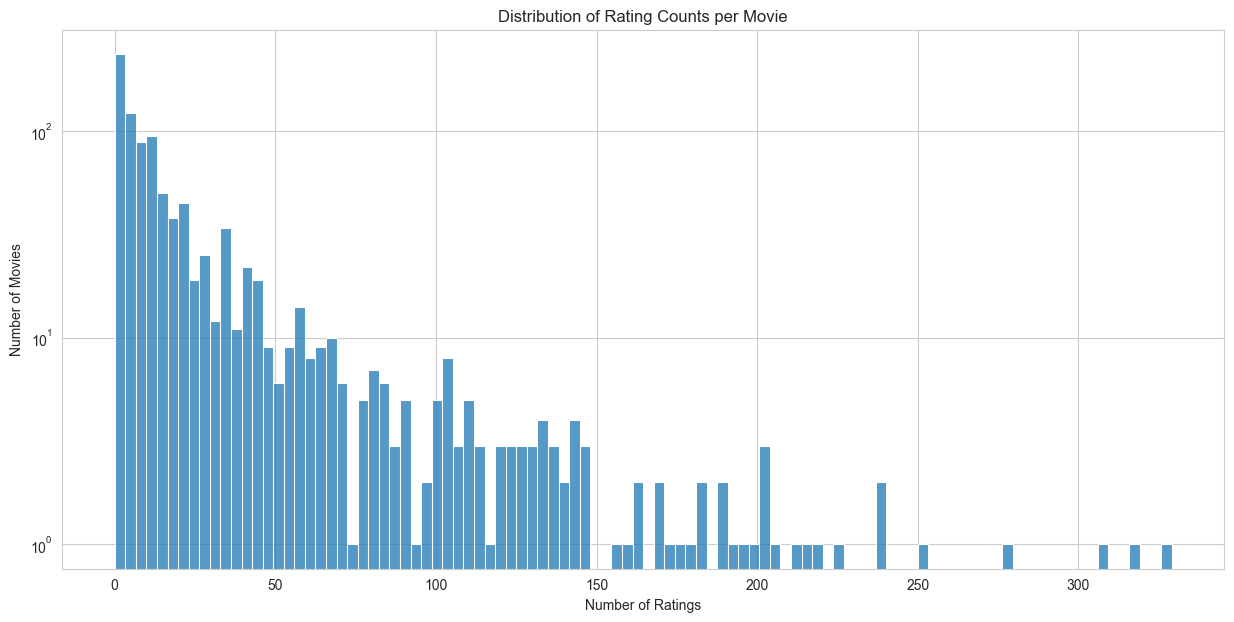

In [4]:
plt.figure(figsize=(15, 7))
sns.histplot(movie_popularity_df['rating_count'], bins=100, kde=False)
plt.title('Distribution of Rating Counts per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log') # Use a log scale on the y-axis to see the distribution more clearly
plt.show()

The log-scale plot clearly shows a long-tail distribution. A vast number of movies have fewer than 10 ratings, while a few blockbusters have over 300.

### Step 4: Define Popularity Tiers

Let's use percentiles to formally define our popularity tiers. This is the same logic that will be used in our defense script to identify unpopular items.

In [5]:
pop_describe = movie_popularity_df['rating_count'].describe(percentiles=[.20, .50, .80, .95])
print("Popularity Distribution Percentiles:")
print(pop_describe)

Popularity Distribution Percentiles:
count    999.000000
mean      29.649650
std       45.036429
min        0.000000
20%        3.000000
50%       12.000000
80%       43.000000
95%      128.100000
max      329.000000
Name: rating_count, dtype: float64


**Analysis and Conclusion:**

- **Unpopular (Bottom 20%):** Movies with just 3 rating.
- **Median (50%):** Half of the movies have 12 or fewer ratings.
- **Popular (Top 5%):** Movies with 128 or more ratings are in the top 5%.

This confirms our strategy for the attack script: we will target movies from the top of this list (e.g., those with >50 ratings) and borrow content from movies at the very bottom (e.g., those with only 1-2 ratings). Our defense will use a percentile-based threshold (e.g., 20th percentile) to define the 'unpopular neighbor' set.